In [48]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from surprise import Dataset
from surprise import SVD
from surprise import SVDpp
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import accuracy
from surprise.model_selection import train_test_split

## 데이터 불러오기

### movies.csv
**title**

제목과 출시 연도가 함께 있는 것으로 보임

**genres**

Adventure, Animation 등 여러 장르가 '|'를 기준으로 달려있는 것으로 보임

### links.csv
**MovieId**

movielens 사이트에서의 영화 id(식별자)

**imdbId**

imdb 사이트에서의 영화 id(식별자)

**tmdbId**

themoviedb 사이트에서의 영화 id(식별자)

### ratings.csv
**rating**

유저가 해당 영화에 대해 매긴 평점으로 0.5 ~ 5.0점의 범위를 가진다(0.5점 단위)

**timestamp**

1970년 1월 1일 자정 이후의 초를 나타낸다. → 바꿔줄 필요가 있다.

In [27]:
movies = pd.read_csv('../ml-latest-small/ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [28]:
# 결측치 확인
movies.isna().any()

movieId    False
title      False
genres     False
dtype: bool

In [29]:
# extract Release Date from title
movies['release_date'] = movies['title'].str.split(' ').str[-1].str[1:5]
movies["title"]= movies.title.str.replace("(\(\d\d\d\d\))","",regex=True)
movies['title'] = movies['title'].str.strip()

# Replace genres with all lowercase
movies["genres"] = movies["genres"].apply(lambda x:x.lower())
# genres data to list
movies["genres"]=movies.genres.str.split("|")
movies

,movieId,title,genres,release_date
0,1,Toy Story,"[adventure, animation, children, comedy, fantasy]",1995
1,2,Jumanji,"[adventure, children, fantasy]",1995
2,3,Grumpier Old Men,"[comedy, romance]",1995
3,4,Waiting to Exhale,"[comedy, drama, romance]",1995
4,5,Father of the Bride Part II,[comedy],1995
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic,"[action, animation, comedy, fantasy]",2017
9738,193583,No Game No Life: Zero,"[animation, comedy, fantasy]",2017
9739,193585,Flint,[drama],2017
9740,193587,Bungo Stray Dogs: Dead Apple,"[action, animation]",2018


In [30]:
# Preprocessing genres to visualizing
Genres = dict()
Genres['action'] = 0
Genres['adventure'] = 0
Genres['animation'] = 0
Genres["children"] = 0
Genres['comedy'] = 0
Genres['crime'] = 0
Genres['documentary'] = 0
Genres['drama'] = 0
Genres['fantasy'] = 0
Genres['film-noir'] = 0
Genres['horror'] = 0
Genres['musical'] = 0
Genres['mystery'] = 0
Genres['romance'] = 0
Genres['mystery'] = 0
Genres['sci-fi'] = 0
Genres['thriller'] = 0
Genres['war'] = 0
Genres['western'] = 0
Genres['no genres'] = 0

Genres

{'action': 0,
 'adventure': 0,
 'animation': 0,
 'children': 0,
 'comedy': 0,
 'crime': 0,
 'documentary': 0,
 'drama': 0,
 'fantasy': 0,
 'film-noir': 0,
 'horror': 0,
 'musical': 0,
 'mystery': 0,
 'romance': 0,
 'sci-fi': 0,
 'thriller': 0,
 'war': 0,
 'western': 0,
 'no genres': 0}

In [31]:
# Counting genres
for genres in movies['genres']:
    for genre in genres:
        if genre in Genres.keys():
            Genres[genre] += 1
        else:
            Genres['no genres'] += 1

In [32]:
a = pd.DataFrame(Genres.keys(), columns=['genre'])
a['count'] = Genres.values()


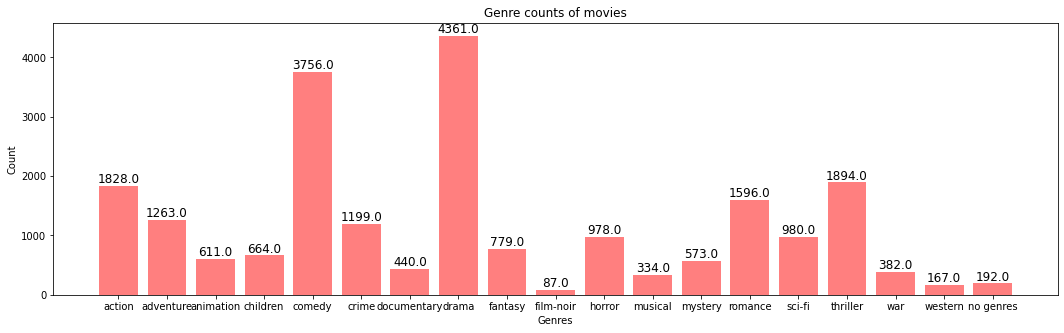

In [34]:
plt.figure(figsize = (18, 5))
plt.title('Genre counts of movies')
plt.xlabel('Genres')
plt.ylabel('Count')
bar = plt.bar(x=a['genre'], height=a['count'], color = 'red', alpha = .5)

for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height, ha='center', va='bottom', size = 12)

가장 많이 포함되어 있는 장르 3개는 Drama, Comedy, thriller로 나타났다.

가장 적게 포함되어 있는 장르 3개는 noir, western, musical로 나타났다.

주어진 장르 형식과 다르게 표시되어 있는 경우는 192개로 나타났다.

[Text(0.5, 1.0, 'Distribution of Release_date')]

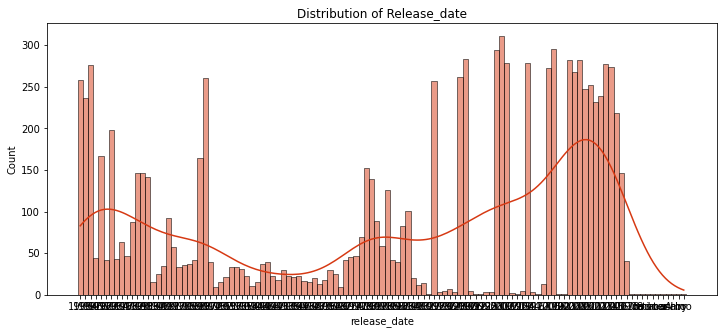

In [35]:
# Check Distribution of Release Date
plt.figure(figsize=(12,5))
sns.histplot(x = movies["release_date"], bins = 10, kde = True, color = "#D63913").set(title = "Distribution of Release_date")

상대적으로 최근 데이터가 많이 포함되어 있다.

In [36]:
print(f"영화 수: {len(movies)}\n")
print(f"장르 종류: {a['genre'].values} \n총 {len(a)}개")

영화 수: 9742

장르 종류: ['action' 'adventure' 'animation' 'children' 'comedy' 'crime'
 'documentary' 'drama' 'fantasy' 'film-noir' 'horror' 'musical' 'mystery'
 'romance' 'sci-fi' 'thriller' 'war' 'western' 'no genres'] 
총 19개


In [37]:
links = pd.read_csv('../ml-latest-small/ml-latest-small/links.csv')
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [38]:
ratings = pd.read_csv('../ml-latest-small/ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


[Text(0.5, 1.0, 'Distribution of Rating variable')]

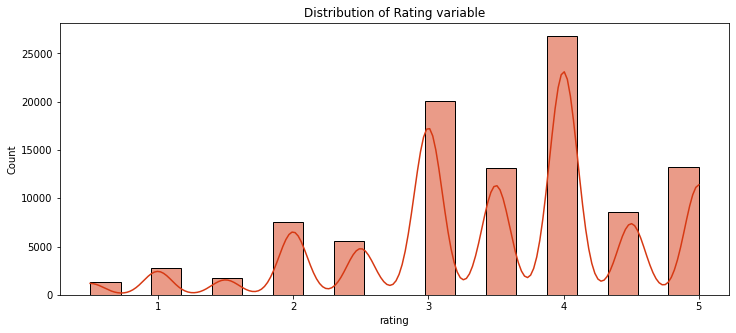

In [40]:
# Check Distribution of ratings
plt.figure(figsize=(12,5))
sns.histplot( x = ratings["rating"], bins = 20, kde = True, color = "#D63913").set(title = "Distribution of Rating variable")

영화 평점의 경우 0.5점 단위로 분포되어 있다.

In [41]:
tags = pd.read_csv('../ml-latest-small/ml-latest-small/tags.csv')
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [42]:
tagCloudDf = pd.merge(tags, movies, on = 'movieId', how = 'inner')
tagCloudDf

,userId,movieId,tag,timestamp,title,genres,release_date
0,2,60756,funny,1445714994,Step Brothers,[comedy],2008
1,2,60756,Highly quotable,1445714996,Step Brothers,[comedy],2008
2,2,60756,will ferrell,1445714992,Step Brothers,[comedy],2008
3,62,60756,comedy,1528934384,Step Brothers,[comedy],2008
4,62,60756,funny,1528934381,Step Brothers,[comedy],2008
...,...,...,...,...,...,...,...
3678,606,5694,70mm,1175638092,Staying Alive,"[comedy, drama, musical]",1983
3679,606,6107,World War II,1178473747,Night of the Shooting Stars (Notte di San Lore...,"[drama, war]",1982
3680,606,7936,austere,1173392334,Shame (Skammen),"[drama, war]",1968
3681,610,3265,gun fu,1493843984,Hard-Boiled (Lat sau san taam),"[action, crime, drama, thriller]",1992


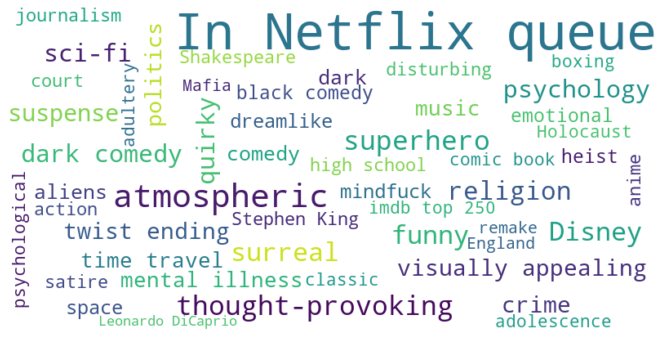

In [43]:
# Group tags by movie
grouped_tags = tagCloudDf.groupby(['movieId'])['tag'].apply(list)

# 각 태그별로 나타나는 횟수 Count
tag_counts = {}
for tags in grouped_tags:
    for tag in tags:
        if tag in tag_counts:
            tag_counts[tag] += 1
        else:
            tag_counts[tag] = 1

# 태그 출현 빈도 순으로 정렬하기
sorted_tags = sorted(tag_counts.items(), key=lambda x: x[1], reverse=True)

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 워드 클라우드 객체로 변환한다. 상위 50개를 출력한다.
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=50)

wordcloud.generate_from_frequencies(tag_counts)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

가장 많이 나타난 태그일수록 글자 크기가 크게 나타난다.
In Netflix 태그가 가장 큰 것으로 보아 넷플릭스의 영화들이 많이 포함된 것을 알 수 있다.
comedy, superhero등 특정 장르의 영화를 연상하게 만드는 단어도 포함되어 있다.

어느정도 필터링을 거친다면 더 좋은 결과를 낼 수 있을 것이라고 판단된다.

Surprise 라이브러리 활용하기

In [44]:
data = Dataset.load_builtin('ml-100k')
train_data, test_data = train_test_split(data, test_size = .25, random_state=1203) # 3:1로 분리

## 1. Model-Based CF
### 1. SVD


In [45]:
svd = SVD(random_state=1203)
svd.fit(train_data)
svd_prediction = svd.test(test_data)
print('prediction type : ', type(svd_prediction), 'size : ', len(svd_prediction))
print('prediction 결과의 최초 5개 추출')
[print(i) for i in svd_prediction[:5]]

print(f'RMSE: {accuracy.rmse(svd_prediction)}')

prediction type :  <class 'list'> size :  25000
prediction 결과의 최초 5개 추출
user: 654        item: 1020       r_ui = 4.00   est = 4.04   {'was_impossible': False}
user: 58         item: 116        r_ui = 5.00   est = 4.23   {'was_impossible': False}
user: 387        item: 641        r_ui = 5.00   est = 3.95   {'was_impossible': False}
user: 22         item: 24         r_ui = 5.00   est = 3.34   {'was_impossible': False}
user: 112        item: 754        r_ui = 4.00   est = 3.64   {'was_impossible': False}
RMSE: 0.9373
RMSE: 0.9372886626594161


### 2. SVD++

In [47]:
svd_pp = SVDpp(random_state=1203)
svd_pp.fit(train_data)
svd_pp_prediction = svd_pp.test(test_data)
print('prediction type : ', type(svd_pp_prediction), 'size : ', len(svd_pp_prediction))
print('prediction 결과의 최초 5개 추출')
[print(i) for i in svd_pp_prediction[:5]]

print(f'RMSE: {accuracy.rmse(svd_pp_prediction)}')

prediction type :  <class 'list'> size :  25000
prediction 결과의 최초 5개 추출
user: 654        item: 1020       r_ui = 4.00   est = 3.69   {'was_impossible': False}
user: 58         item: 116        r_ui = 5.00   est = 4.40   {'was_impossible': False}
user: 387        item: 641        r_ui = 5.00   est = 4.11   {'was_impossible': False}
user: 22         item: 24         r_ui = 5.00   est = 3.68   {'was_impossible': False}
user: 112        item: 754        r_ui = 4.00   est = 3.62   {'was_impossible': False}
RMSE: 0.9211
RMSE: 0.9211370867510765


SVD++ 모델의 경우 SVD에 비해 성능이 다소 높게 나왔다.

## 2. Memory based CF

### 2.1 KNNBasic

In [49]:
knn_basic = KNNBasic(random_state = 1203)
knn_basic.fit(train_data)
knn_basic_prediction = knn_basic.test(test_data)

print(f'prediction type: {type(knn_basic)} size: {len(knn_basic_prediction)}')
print('prediction 결과의 최초 5개 추출')
[print(i) for i in knn_basic_prediction[:5]]

print(f'RMSE: {accuracy.rmse(knn_basic_prediction)}')

Computing the msd similarity matrix...
Done computing similarity matrix.
prediction type: <class 'surprise.prediction_algorithms.knns.KNNBasic'> size: 25000
prediction 결과의 최초 5개 추출
user: 654        item: 1020       r_ui = 4.00   est = 3.99   {'actual_k': 21, 'was_impossible': False}
user: 58         item: 116        r_ui = 5.00   est = 4.10   {'actual_k': 40, 'was_impossible': False}
user: 387        item: 641        r_ui = 5.00   est = 4.31   {'actual_k': 21, 'was_impossible': False}
user: 22         item: 24         r_ui = 5.00   est = 3.62   {'actual_k': 40, 'was_impossible': False}
user: 112        item: 754        r_ui = 4.00   est = 3.41   {'actual_k': 39, 'was_impossible': False}
RMSE: 0.9840
RMSE: 0.9839741770326332


### 2.2 KNNwithMeans

In [50]:
knn_means = KNNWithMeans(random_state = 1203)
knn_means.fit(train_data)
knn_means_prediction = knn_means.test(test_data)

print(f'prediction type: {type(knn_means)} size: {len(knn_means_prediction)}')
print('prediction 결과의 최초 5개 추출')
[print(i) for i in knn_means_prediction[:5]]

print(f'RMSE: {accuracy.rmse(knn_means_prediction)}')

Computing the msd similarity matrix...
Done computing similarity matrix.
prediction type: <class 'surprise.prediction_algorithms.knns.KNNWithMeans'> size: 25000
prediction 결과의 최초 5개 추출
user: 654        item: 1020       r_ui = 4.00   est = 3.94   {'actual_k': 21, 'was_impossible': False}
user: 58         item: 116        r_ui = 5.00   est = 4.15   {'actual_k': 40, 'was_impossible': False}
user: 387        item: 641        r_ui = 5.00   est = 4.07   {'actual_k': 21, 'was_impossible': False}
user: 22         item: 24         r_ui = 5.00   est = 3.26   {'actual_k': 40, 'was_impossible': False}
user: 112        item: 754        r_ui = 4.00   est = 3.55   {'actual_k': 39, 'was_impossible': False}
RMSE: 0.9534
RMSE: 0.9534297467139629


### 성능 비교하기

RMSE: 0.9373
RMSE: 0.9211
RMSE: 0.9840
RMSE: 0.9534


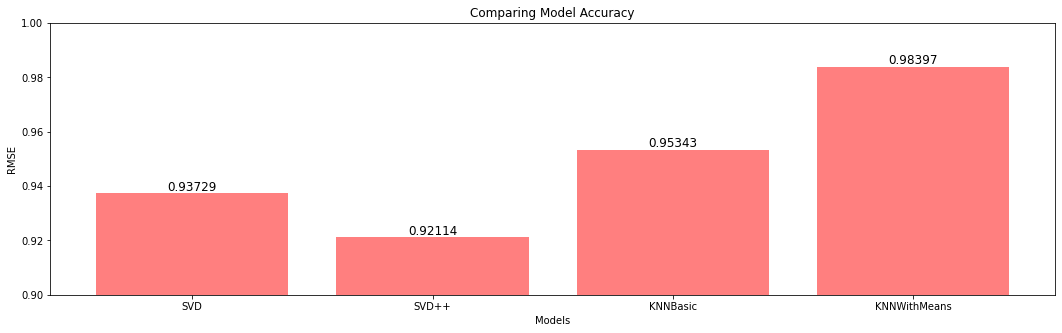

In [62]:
modelsAccuracy = pd.DataFrame({accuracy.rmse(svd_prediction), accuracy.rmse(svd_pp_prediction), accuracy.rmse(knn_basic_prediction), accuracy.rmse(knn_means_prediction)}, columns= ['RMSE'])
modelsAccuracy['Model'] = ['SVD', 'SVD++', 'KNNBasic', 'KNNWithMeans']

plt.figure(figsize = (18, 5))
plt.title('Comparing Model Accuracy')
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.ylim(0.9, 1)
bar = plt.bar(x=modelsAccuracy.Model, height=modelsAccuracy.RMSE, color = 'red', alpha = .5)

for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.5f' % height, ha='center', va='bottom', size = 12)

모델 성능을 비교해 본 결과 KNNWithMeans, KNNBasic, SVD, SVD++ 순으로 RMSE 값이 높았다.

즉, SVD++이 가장 성능이 좋은 것으로 확인되었다.

### Keras로 MF 구현하기

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 1, 200)       122200      ['input_4[0][0]']                
                                                                                                  
 embedding_6 (Embedding)        (None, 1, 200)       38722000    ['input_5[0][0]']                
                                                                                            

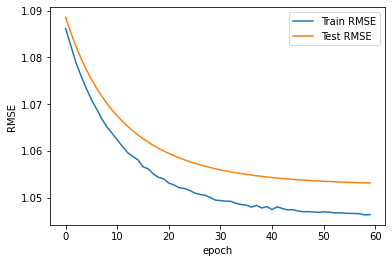

1/1 [==============================] - 0s 285ms/step
Actuals: 
        userId  movieId  rating
68570     446      593       5
32682     222     3173       4
2068       18    37733       4
90644     590     1032       4
68145     438     8984       2
47320     307     5255       2

Predictions: 
 [[3.4232116]
 [3.2981713]
 [3.3687072]
 [3.2903483]
 [3.2888358]
 [3.0636854]]
788/788 [==============================] - 1s 1ms/step


1.0545829441626977

In [63]:
ratings = ratings[['userId', 'movieId', 'rating']].astype(int)            # timestamp 제거

# train test 분리
from sklearn.utils import shuffle
TRAIN_SIZE = 0.75
ratings = shuffle(ratings) # 데이터 섞기
cutoff = int(TRAIN_SIZE * len(ratings)) # TRAIN_SIZE: 75%, TEST_SIZE: 25%
ratings_train = ratings.iloc[:cutoff]
ratings_test = ratings.iloc[cutoff:]

# 필요한 모듈 불러오기
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adamax

# Variable 초기화 
K = 200                             # Latent factor 수 
mu = ratings_train.rating.mean()    # 전체 평균 
M = ratings.userId.max() + 1        # 유저 수
N = ratings.movieId.max() + 1       # 영화 수

# RMSE 계산 함수 정의
def RMSE(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

# 모델
user = Input(shape=(1, ))                                               # 유저 입력
item = Input(shape=(1, ))                                               # 아이템 입력
P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)        # (M, 1, K) => (611, 1, 200)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)        # (N, 1, K) => (193610, 1, 200)
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)          # User bias term (611, 1, )
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)          # Movie bias term (193610, 1, )

R = layers.dot([P_embedding, Q_embedding], axes=2)                      # (1, 1, 1)
R = layers.add([R, user_bias, item_bias])
R = Flatten()(R)                                                        # (1, 1)

# Model setting
model = Model(inputs=[user, item], outputs=R)
model.compile(loss=RMSE, optimizer=SGD(), metrics=[RMSE])
model.summary()

# Model fitting
result = model.fit(
  x=[ratings_train.userId.values, ratings_train.movieId.values],
  y=ratings_train.rating.values - mu,
  epochs=60,
  batch_size=256,
  validation_data=(
    [ratings_test.userId.values, ratings_test.movieId.values],
    ratings_test.rating.values - mu
  )
)

# Plot RMSE
import matplotlib.pyplot as plt
plt.plot(result.history['RMSE'], label="Train RMSE")
plt.plot(result.history['val_RMSE'], label="Test RMSE")
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

# Prediction
user_ids = ratings_test.userId.values[0:6]
movie_ids = ratings_test.movieId.values[0:6]
predictions = model.predict([user_ids, movie_ids]) + mu
print("Actuals: \n", ratings_test[0:6])
print( )
print("Predictions: \n", predictions)

# RMSE check
def RMSE2(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

user_ids = ratings_test.userId.values
movie_ids = ratings_test.movieId.values
y_pred = model.predict([user_ids, movie_ids]) + mu
y_pred = np.ravel(y_pred, order='C')
y_true = np.array(ratings_test.rating)

RMSE2(y_true, y_pred)


RMSE: 0.9373
RMSE: 0.9211
RMSE: 0.9840
RMSE: 0.9534


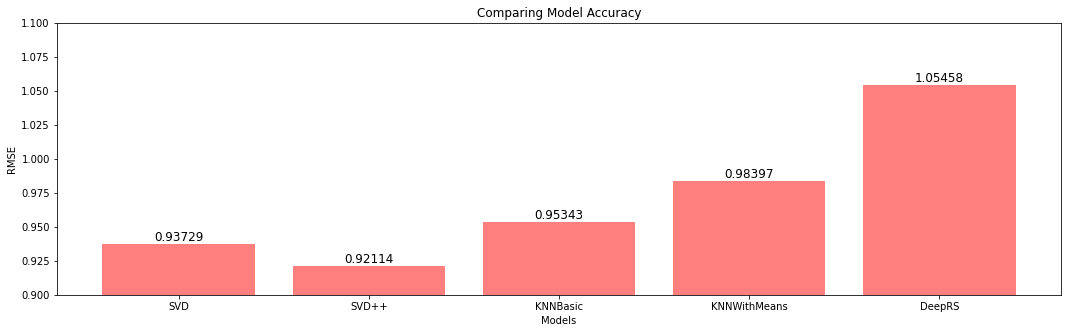

In [65]:
modelsAccuracy = pd.DataFrame({accuracy.rmse(svd_prediction), accuracy.rmse(svd_pp_prediction), accuracy.rmse(knn_basic_prediction), accuracy.rmse(knn_means_prediction), RMSE2(y_true, y_pred)}, columns= ['RMSE'])
modelsAccuracy['Model'] = ['SVD', 'SVD++', 'KNNBasic', 'KNNWithMeans', 'DeepRS']

plt.figure(figsize = (18, 5))
plt.title('Comparing Model Accuracy')
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.ylim(0.9, 1.1)
bar = plt.bar(x=modelsAccuracy.Model, height=modelsAccuracy.RMSE, color = 'red', alpha = .5)

for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.5f' % height, ha='center', va='bottom', size = 12)

Keras를 이용하여 MF방식의 추천 시스템을 구현하였지만 성능이 좋지 않았다. 물론, 모델 학습 곡선을 보면 충분히 더 최적화될 여지가 보이기는 하지만, 너무 오래 걸려서 학습을 60번만 반복하였다. 그럼에도 불구하고 성능은 좋지 않았다.